In [0]:
%matplotlib inline

In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import time
import os
import copy
import random
import math
import pickle
import torch.nn.functional as F
from functools import reduce
from skimage import io, transform
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

plt.ion()   # interactive mode

In [2]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_folder = 'drive/My Drive/computer-vision/project'

# root_folder = 'drive/My Drive/project'

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]
def clear_non_ascii(word):
    res = ''
    for letter in word:
        if (ord(letter) < 128):
            res += letter
    return res

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, ingredients, nutritions = sample['image'], sample['ingredients'], sample['nutritions']
        
        try:
            # convert images from RGBA to RGB
            image = Image.fromarray(image)
            image = image.convert('RGB')
            image = np.array(image)
        except:
            pass
        image = transform.resize(image, (224, 224, 3))
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'ingredients': torch.from_numpy(ingredients),
                'nutritions': torch.from_numpy(nutritions)}

class FoodDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = None
        self.metadata = None
        self.ingredients = None
        self.prepare_metadata()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        row = self.images.iloc[idx]
        im_name, im_class = row['image_name'], row['class']
        try:
            image = io.imread(os.path.join(self.root_dir, 'downloads', im_class, im_name))
        except Exception as err:
            print(im_name, im_class)
        rows = self.metadata[self.metadata['name'] == im_class.strip()]
        row = rows.iloc[random.choice(list(range(len(rows))))].to_dict() # random.choice is for getting a random row if there are more than 1 recipes sharing one name
        ingredients = self.ingredient_to_sparse(row['ingredients'])
        del row['image']
        del row['ingredients']
        del row['name']
        nutritions = self.nutritions_to_array(row)
        sample = {
            'image': image,
            'nutritions': nutritions,
            'ingredients': ingredients
        }
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def ingredient_to_sparse(self, target_ingredients):
        zero_array = np.zeros(len(self.ingredients), dtype=int)
        ingredient_locations = map(lambda string: self.ingredients.index(string), target_ingredients)
        for loc in list(ingredient_locations):
            zero_array[loc] = 1
        return zero_array
    
    def nutritions_to_array(self, row):
        calories, carbs, fat, protein = row['calories'], row['carbs'], row['fat'], row['protein']
        as_array = np.array([calories, carbs, fat, protein])
        return as_array
      
    def prepare_metadata(self):
        food = pd.read_csv(os.path.join(self.root_dir, 'data1.csv'))
        food['ingredients'] = food['ingredients'].apply(lambda cell: cell.split('|'))
        food['name'] = food['name'].apply(lambda cell: cell.replace('\"', '')) # Some cells contain " which causes problems with the file system
        food['name'] = food['name'].apply(lambda cell: cell.replace('/', '_')) # Some cells contain / which causes problems with the file system
        food['name'] = food['name'].apply(lambda cell: cell.replace('  ', ' ')) # Some cells has 2 spaces instead 1 one
        food['name'] = food['name'].apply(lambda cell: clear_non_ascii(cell))
        
        scaler = MinMaxScaler()
        food[['calories', 'fat', 'carbs', 'protein']] = scaler.fit_transform(food[['calories', 'fat', 'carbs', 'protein']])
        self.scaler = scaler
        
        ingredients = list(set(flatten(list(food['ingredients']))))
        self.metadata = food
        self.ingredients = sorted(ingredients)

        rows = []
        
        for name in os.listdir(os.path.join(self.root_dir, 'downloads')):
            row = food[food['name']==name.strip()]
            if not len(row): continue
            images = os.listdir(os.path.join(self.root_dir, 'downloads', name))
            new_row = list(map(lambda im: [im, name], images))
            rows.extend(new_row)
        df = pd.DataFrame(rows, columns=['image_name', 'class']).sample(n=5000)
        self.images = df

In [0]:
image_dataset = FoodDataset(root_folder, transform=transforms.Compose([
    ToTensor()
]))

In [0]:
filename = os.path.join(root_folder, 'image_dataset')
outfile = open(filename,'wb')

pickle.dump(image_dataset, outfile)

In [0]:
# Load the image_dataset
with open(os.path.join(root_folder, 'image_dataset'), 'rb') as f:
    image_dataset = pickle.load(f)

## FINE TUNING

---



In [0]:
def drawGraphs(losses):
    plt.plot(losses['train'], )
    plt.plot(losses['val'])
    plt.title('Model training loss graph')
    plt.ylabel("Loss")
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [0]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    root = "drive/My Drive/computer-vision"
    
    loss_history = {'train': list(),
                   'val': list()}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, batch in enumerate(dataloaders[phase]):
                print("\rBatch {} / {}".format(i, dataset_sizes[phase]/8), sep=' ', end='', flush=True)
                inputs = batch['image']
                labels = batch['ingredients']

                inputs = inputs.float()
                labels = labels.float()

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss
            
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and best_loss > epoch_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        
        with open(os.path.join(root, 'tempModel.pck'), 'wb') as f:
            pickle.dump(model, f)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    drawGraphs(loss_history)
    
    return model, loss_history

In [0]:
def splitDataset(dataset, validation_split=0.2, shuffle=True, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    
    if shuffle :
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    
    return train_sampler, valid_sampler

In [0]:
train_sampler, valid_sampler = splitDataset(image_dataset)

In [0]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_dataset, batch_size=8,
                                        sampler=train_sampler),
    'val': torch.utils.data.DataLoader(image_dataset, batch_size=8,
                                        sampler=valid_sampler) 
}

dataset_sizes = {
    'train': len(train_sampler),
    'val': len(valid_sampler)
}

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 957)

model_conv = model_conv.to(device)


criterion = nn.MSELoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
# Training ResNet18
model_conv, losshist = train_model(model_conv, dataloaders, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

Epoch 1/2
----------
Batch 100 / 500.0

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Batch 499 / 500.0train Loss: 780.8242
Batch 16 / 125.0

KeyboardInterrupt: ignored

In [0]:
torch.save(model_conv, os.path.join(root_folder, 'resnet18.pck'))

In [0]:
model_conv = torch.load(os.path.join(root_folder, 'resnet18.pck'))

In [0]:
resnet18 = torchvision.models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 957)

resnet18 = resnet18.to(device)

In [0]:
# We can iterate inside resnet layer.
child_counter = 0
for child in resnet18.children():
    print(" child", child_counter, "is:")
    print(child)
    child_counter += 1

In [0]:
child_counter = 0
for child in resnet18.children():
    if child_counter < 6:
        print("child ",child_counter," was frozen")
        for param in child.parameters():
            param.requires_grad = False
    elif child_counter == 6:
        children_of_child_counter = 0
        for children_of_child in child.children():
            if children_of_child_counter < 1:
                for param in children_of_child.parameters():
                    param.requires_grad = False
                    print('child ', children_of_child_counter, 'of child', child_counter,' was frozen')
            else:
                print('child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
            children_of_child_counter += 1
    else:
        print("child ",child_counter," was not frozen")
    child_counter += 1

In [0]:
criterion = nn.MSELoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
# Training ResNet18
resnet18, losshist = train_model(resnet18, dataloaders, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=20)

In [0]:
torch.save(model_conv, os.path.join(root_folder, 'resnet18_Adv.pck'))

# Ingredients => Nutritions Training

In [0]:
def train_model_fc(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    loss_history = {'train': list(),
                   'val': list()}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('{} phase'.format(phase))
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            i = 0
            # Iterate over data.
            for batch in dataloaders[phase]:
                i += 1
                print("\rBatch {} / {}".format(i, dataset_sizes[phase]/8), sep=' ', end='', flush=True)
                inputs = batch['ingredients']
                labels = batch['nutritions']
                
                inputs = inputs.float()
                labels = labels.float()
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #preds = outputs()
                    #_, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss 
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and best_loss > epoch_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    drawGraphs(loss_history)
    
    with open(os.path.join(root_folder, 'model_fc_9NN_noDivision.pck'), 'wb') as f:
            pickle.dump(best_model_wts, f)
    return model, loss_history

In [0]:
n_in, m_in,  n_out = 957, 1024, 4
q_in, p_in, r_in = 512, 2048, 4096
class NN(nn.Module):
    def __init__(self):        
        super(NN, self).__init__()
        self.fc1 = nn.Linear(n_in, p_in)
        self.fc2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(p_in, p_in)
        self.fc4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(p_in, p_in)
        self.fc6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(p_in, m_in)
        self.fc8 = nn.Dropout(0.5)
        self.fc9 = nn.Linear(m_in, m_in)
        self.fc10 = nn.Dropout(0.5)
        self.fc11= nn.Linear(m_in, n_out)

   
    def forward(self, x):
        x = self.fc2(F.relu(self.fc1(x)))
        x = self.fc4(F.relu(self.fc3(x)))
        x = self.fc6(F.relu(self.fc5(x)))
        x = self.fc8(F.relu(self.fc7(x)))
        x = self.fc10(F.relu(self.fc9(x)))
        x = self.fc11(x)
        return x

In [0]:
# model_fc = NN()
model_fc = model = torch.nn.Sequential(
    torch.nn.Linear(n_in, p_in),
    torch.nn.ReLU(),
    torch.nn.Linear(p_in, p_in),
    torch.nn.ReLU(),
    nn.Dropout(0, 5),
    torch.nn.Linear(p_in, p_in),
    torch.nn.ReLU(),
    torch.nn.Linear(p_in, p_in),
    torch.nn.ReLU(),
    nn.Dropout(0, 5),
    torch.nn.Linear(p_in, n_out),
)

model_fc =model_fc.to(device)
  
# Construct the loss function
criterion = torch.nn.MSELoss()
optimizer_fc = torch.optim.Adam(model_fc.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)


Epoch 0/9
----------
train phase
Batch 100 / 500.0

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Batch 500 / 500.0train Loss: 7.7216
val phase
Batch 125 / 125.0val Loss: 1.5538

Epoch 1/9
----------
train phase
Batch 500 / 500.0train Loss: 5.1286
val phase
Batch 125 / 125.0val Loss: 0.9871

Epoch 2/9
----------
train phase
Batch 500 / 500.0train Loss: 4.4560
val phase
Batch 125 / 125.0val Loss: 1.2669

Epoch 3/9
----------
train phase
Batch 500 / 500.0train Loss: 2.9706
val phase
Batch 125 / 125.0val Loss: 0.5641

Epoch 4/9
----------
train phase
Batch 500 / 500.0train Loss: 2.0061
val phase
Batch 125 / 125.0val Loss: 0.7048

Epoch 5/9
----------
train phase
Batch 500 / 500.0train Loss: 2.0567
val phase
Batch 125 / 125.0val Loss: 0.7472

Epoch 6/9
----------
train phase
Batch 500 / 500.0train Loss: 1.0631
val phase
Batch 125 / 125.0val Loss: 0.2702

Epoch 7/9
----------
train phase
Batch 500 / 500.0train Loss: 0.5109
val phase
Batch 125 / 125.0val Loss: 0.2416

Epoch 8/9
----------
train phase
Batch 500 / 500.0train Loss: 0.4856
val phase
Batch 125 / 125.0val Loss: 0.2255

Epoch 9

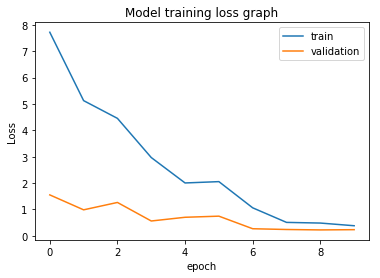

In [71]:
# Training ResNet18
model_fc, losses = train_model_fc(model_fc, dataloaders, criterion, optimizer_fc,
                         exp_lr_scheduler, num_epochs=10)

In [0]:
torch.save(model_fc, os.path.join(root_folder, 'model_fc.torch'))

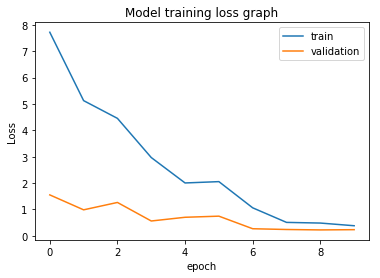

In [74]:
drawGraphs(losses)

## Testing the model with images

In [73]:
def resize_image(image):
    image = transform.resize(image, (224, 224, 3))
        
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(np.array([image]))
    return image

def get_ingredients_from_matrix(dataset, ingredients):
    results = []
    for index, ingredient in enumerate(ingredients):
        if (ingredient):
            results.append(dataset.ingredients[index])
    return results
            
def denormalize_nutritients(dataset, nutritients):
    nutritients = dataset.scaler.inverse_transform([nutritients])[0]
    return {
        'calories': nutritients[0],
        'fat': nutritients[1],
        'carbs': nutritients[2],
        'protein': nutritients[3],
    }

def run_model(model_conv, model_fc, dataset, image):
    image = resize_image(image)
    model_conv.eval()
    model_fc.eval()
    image = image.float()
    image = image.to(device)
    outputs_conv = model_conv(image)
    
    outputs_nutritient = model_fc(outputs_conv)
    
    outputs_nutritient = outputs_nutritient.detach().cpu().numpy()[0]
    print(outputs_nutritient)
    outputs_conv = outputs_conv.detach().cpu().numpy()[0]
    threshold = 0.95
    outputs_conv[outputs_conv >= threshold] = 1
    outputs_conv[outputs_conv < threshold] = 0
    
    ingredients = get_ingredients_from_matrix(dataset, outputs_conv)
    nutritients = denormalize_nutritients(dataset, outputs_nutritient)
    return ingredients, nutritients

def test_models(image_name):
    image_path = os.path.join(root_folder, image_name)
    image = io.imread(image_path)
    ingredients, nutritients = run_model(model_conv, model_fc, image_dataset, image)
    return ingredients, nutritients

test_images = ['nohut-yemegi.png', 'imam-bayildi.jpg']
for test_image in test_images:
    print('Testing {}'.format(test_image))
    ingredients, nutritions = test_models(test_image)
    print(ingredients)
    print(nutritions)
    print('-' * 20)

Testing nohut-yemegi.png
[0.14840288 0.1047461  0.09721258 0.06526579]
['Bouillon cube', 'Cornbread', 'Foie gras', 'French fries', 'Garlic', 'Grits', 'Half and half', 'Mango', 'Nước chấm', 'Plum tomato', 'Red cabbage', 'Royal icing', 'Spare ribs', 'Sriracha sauce', 'Vegetable oil', 'Yellow onion']
{'calories': 1620.2380155631333, 'fat': 106.28377175028066, 'carbs': 127.12932003173113, 'protein': 72.40178777032554}
--------------------
Testing imam-bayildi.jpg
[0.11248967 0.12807585 0.04610611 0.04478601]
['Acini di pepe', 'Ale', 'Banana', 'Carrot', 'Cocoa bean', 'Corn kernel', 'Herb', 'Rib eye steak', 'Tart']
{'calories': 1228.143525474832, 'fat': 129.95600085029093, 'carbs': 60.29507010272733, 'protein': 49.682796556562295}
--------------------
